In [1]:
!nvidia-smi

Fri Nov  5 08:24:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           On   | 00000000:05:00.0 Off |                  Off |
| 30%   40C    P0    34W / 300W |      1MiB / 48685MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import time 
import random 
import glob
#from google.colab import drive
from tqdm import tqdm

import re 
import os
import random
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.nn.modules.linear import Linear 
from torch.optim.optimizer import Optimizer, required 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

from PIL import Image
import argparse
import matplotlib.pyplot as plt

In [3]:
# Data Utils
to_tensor_trans = transforms.ToTensor()
def get_img_paths(src_dir):
    return [os.path.join(src_dir, img_name) for img_name in os.listdir(src_dir)]

class DataGenerator(Dataset):
    def __init__(self, phase, img_dir, s=0.5):
        self.phase = phase
        self.img_paths = get_img_paths(img_dir)
        #print(self.img_paths[0:10])
        self.s = s
        self.transforms = transforms.Compose([
                                                transforms.RandomHorizontalFlip(0.5),
                                                transforms.RandomResizedCrop((66, 200), (0.8, 1.0)),
                                                transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                    0.8*self.s, 
                                                                                                                    0.8*self.s, 
                                                                                                                    0.2*self.s)], p=0.8),
                                                                    transforms.RandomGrayscale(p=0.2)]),
                                                transforms.GaussianBlur(7),
                                            ])


        # These are imagenet channel wise means and stds, change them to fit Honda dataset?
        self.mean = np.array([[[[0.485]], [[0.456]], [[0.406]]]])
        self.std = np.array([[[[0.229]], [[0.224]], [[0.225]]]])

    def __len__(self):
        
        return len(self.img_paths)
    
    def _get_img(self, idx):
        path = self.img_paths[idx]
        img = Image.open(path).convert("RGB")
        # Putting this hear instead of in self.transforms so it will work for both train/val
        x = to_tensor_trans(img)
        return x


    def __getitem__(self, idx):
        x = self._get_img(idx)
        x1 = self.augment(x)
        x2 = self.augment(x)

        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)

        return x1, x2
    
    def preprocess(self, frame):
        frame = (frame - self.mean) / self.std
        return frame
    
    def augment(self, frame, transformations=None):
        if self.phase == 'train':
            return self.transforms(frame)
        else:
            return frame # Dont we need these transformations to be applied at validation ?


In [4]:
# Optimizer

EETA_DEFAULT = 0.001

class LARS(Optimizer):
    """
    Layer wise Adaptive Rate Scaling
    exclude_from_weight_decay = 
    exclude_from_layer_adaptation =
    classic_momentum = whether or not to use the regular momentum 
    """
    def __init__(self, params, 
    lr = required, momentum= 0.9, 
    use_nesterov= False, 
    weight_decay= 0.0, 
    exclude_from_weight_decay = None, 
    exclude_from_layer_adaptation = None, 
    classic_momentum=True,
    eeta = EETA_DEFAULT):

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.ge(0),
                        torch.where(
                            g_norm.ge(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(other=grad, alpha=scaled_lr)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True


In [5]:
# Loss
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__() ## Why Imrealun?
        self.batch_size = batch_size 
        self.temperature = temperature 

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum") # For what? Is this CE loss? Internally simCLR loss uses CE
        self.similarity_fn = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        """
        We want to create positive and negative pairs
        positive pairs come from the augmentations of the same image
        negative pairs cant contain augmented version of same image
        """
        """
        Within a batch, for every image, the 2(N-1) images i.e., excluding 2 versions of its augmented pair
        is a negative pair
        """
        
        N = 2*batch_size # Each data point gets 2 augmentations
        mask = torch.ones((N,N), dtype=bool)
        mask = mask.fill_diagonal_(0) # A diagonal matrix of 0 as components

        # Going through 0 to batch_size but working in 2 dimensions
        for i in range(batch_size):
            mask[i, batch_size + i] = 0 # 5, 5+N ; this should not be a pair
            mask[batch_size+ i, i] = 0 # 5+N, 5
        # Just return a diagonal matrix that masks augmented versions that came from same image
        return mask

    def forward(self, z_i, z_j):
        """
        The Loss function in the paper is given between each data pair, is it?
        But here, we deal with a batch
        z_i = batch of images with augmented versions 1 (which may all be different)
        z_j = batch of images with second version of aug
        """
        N = 2 * self.batch_size 
        z = torch.cat((z_i, z_j), dim =0) # The 2 augmented images concat to 1 

        # Similarity between 2 augmented versions, must be a 2d matrix 
        sim = self.similarity_fn(z.unsqueeze(1), z.unsqueeze(0))/ self.temperature

        # torch.diag (if 1d, inputs are diagonal elemets) 
        # get just the diagonal of similarity matrix, diagonal_no = self.batch_size 
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N,1) #??
        negative_samples = sim[self.mask].reshape(N, -1)

        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #This is strange, positive_samples.device

        logits = torch.cat((positive_samples, negative_samples), dim =1)

        loss = self.criterion(logits, labels) # CE ?
        loss /= N
        return loss 

In [6]:
# Model
class Identity(nn.Module):
    """
    Identity Mapping
    """
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    """
    A single Linear Layer and whether or not to use BN 1D
    This is used by the projection head below
    """
    def __init__(self, in_features, out_features, use_bias = True, use_bn = False, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features 
        self.use_bias = use_bias 
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features, self.out_features, bias = self.use_bias and not self.use_bn)
        if self.use_bn:
            self.bn = nn.BatchNorm1d(self.out_features)
    def forward(self, x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)

        return x 

class ProjectionHead(nn.Module):
    """
    Projection could be a linear or non linear mapping
    hidden features ? No. of features in the intermediate layers
    """
    def __init__(self, in_features, hidden_features, out_features, head_type= 'nonlinear', **kwargs):
        super(ProjectionHead, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features 
        self.head_type = head_type 

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features, self.out_features, False, True)

        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features, self.hidden_features, True, True),
                nn.ReLU(), 
                LinearLayer(self.hidden_features, self.out_features, False, False)) # Last layer does not use BN

    def forward(self, x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    """
    The model to be used for Pretraining = ResNet50
    Plus a projection head on top 
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model 

        self.encoder = models.resnet50(pretrained= False) ## Default was True, changed to False . Why a pretrained resnet50?

        # The input size of this pre-trained may be different (mostly its tuned for imagenet), 
        # modify it to suit our needs, why do we change this?

#         self.encoder.conv1 = nn.Conv2d(3, 64,kernel_size=(3,3), stride = (1,1), bias= False)
#         self.encoder.maxpool = Identity() ## Essentially dont do maxpool
        self.encoder.fc = nn.Linear(2048,2048) # This also does nothing i.e. identity mapping

#         for p in self.encoder.parameters():
#             p.requires_grad = True

        self.projector = ProjectionHead(2048, 2048, 128) # Because the encoder last fc has output of 1000


    def forward(self, x):
        out = self.encoder(x) # Encoder
        #print(out.size())
        xp = self.projector(torch.squeeze(out)) # Projection head
        return xp

In [7]:
class Trainer:
    def __init__(self):

        # Arguments
        self.seed = 99
        self.train_batch_size =  768 # Image sizes larger, so batch size reduced
        self.val_batch_size = 768
        self.temperature= 0.5
        self.train_epochs = 200
        self.lr = 1.2 #0.9 #4.8 (0.3 x Batch size )/ 256
        self.weight_decay = 1e-6
        self.dataset_src ='/home/ubuntu/lambda_data'
        self.writer = SummaryWriter()
        self.writer = SummaryWriter()
        self.logfile =  open('/home/ubuntu/logs/approach_3_logfile.txt', 'w')

        print("\n--------------------------------")
        self.logfile.write("--------------------------------")
        print("Seed: ", self.seed)
        self.logfile.write("Seed: {}".format(self.seed))

        # Set seeds
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device Assigned to: ", self.device)
        self.logfile.write("Device Assigned to: {}".format(self.device))

        ## Data Loading operations
        print("Data Directory: ", self.dataset_src)
        self.logfile.write("Data Directory: {}".format(self.dataset_src))

        train_dir = os.path.join(self.dataset_src, "trainHonda100k/")
        val_dir = os.path.join(self.dataset_src, "valHonda100k/")

       
        self.datagen_train = DataGenerator('train', train_dir)
        self.train_dataloader = DataLoader(self.datagen_train, self.train_batch_size,  num_workers = 14, prefetch_factor=8, drop_last = True, shuffle=True)

        datagen_val = DataGenerator('val', val_dir)
        self.val_dataloader = DataLoader(datagen_val, self.val_batch_size,  num_workers = 14, prefetch_factor=8, drop_last = True)


        # datagen_test = DataGenerator('test', val_dir)
        # self.test_dataloader = DataLoader(datagen_test, self.val_batch_size, drop_last = True)

        print("\nTraining data size: {} X {}".format(len(self.train_dataloader), self.train_batch_size))
        print("Validation data size: {} X {}\n".format(len(self.val_dataloader), self.val_batch_size))
        self.logfile.write("Training data size: {} X {}".format(len(self.train_dataloader), self.train_batch_size))
        self.logfile.write("Validation data size: {} X {}\n".format(len(self.val_dataloader), self.val_batch_size))

        self.net = PreModel('resnet50').to(self.device)
        print(self.net)
        self.logfile.write("{}".format(self.net))

        self.criterion = SimCLR_Loss(self.train_batch_size, self.temperature)
        self.optimizer = LARS([params for params in self.net.parameters() if params.requires_grad],
            lr=self.lr,
            weight_decay=self.weight_decay,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )


        # I removed both of the schedulers as they resulted in some errors being thrown in regards to memory
        # I plan to add them back after doing the downstream task, but for now, I just want to get the whole pipeline working

        self.warmupscheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambda epoch: (epoch+1) / 10.0, verbose=True)

        # # The default for last_epoch is -1 to begin with so I'm not sure why they specify it here
        self.mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, 500, eta_min=0.05, last_epoch=-1, verbose=True) #500 means number of iterations for first restart

        print("\n--------------------------------")
        print("Total No. of Trainable Parameters: ",sum(p.numel() for p in self.net.parameters() if p.requires_grad))
        self.logfile.write("--------------------------------")
        self.logfile.write("Total No. of Trainable Parameters: {}".format(sum(p.numel() for p in self.net.parameters() if p.requires_grad)))

    def train(self):
        train_loss_collector = np.zeros(self.train_epochs)
        val_loss_collector = np.zeros(self.train_epochs) 

        best_loss = float('inf')
        print("\n#### Started Training ####")
        self.logfile.write("\n#### Started Training ####\n")

        for i in range(self.train_epochs):
            self.net.train()

            if i==0:
                myfile = open('/home/ubuntu/logs/approach_3_model_init_weights.txt', 'w')
                myfile.write("SEED = %s\n" % self.seed)
                print("Writing Model Initial Weights to a file\n")
                for param in self.net.parameters():
                    myfile.write("%s\n" % param.data)
                myfile.close()

            start = time.time()
            batch_loss_train = 0 

            print("Ep. {}/{}:".format(i, self.train_epochs), end="\t")
            self.logfile.write("Ep. {}/{}:\t".format(i, self.train_epochs))
                            
            for bi, (x_i, x_j) in enumerate(self.train_dataloader):
                x_i = x_i.squeeze().to(self.device).float()
                x_j = x_j.squeeze().to(self.device).float()
        
                z_i = self.net(x_i)
                z_j = self.net(x_i)

                self.optimizer.zero_grad() 
                loss = self.criterion(z_i, z_j)

                loss.backward()
                self.optimizer.step() 

                loss_np = loss.cpu().detach().numpy()
                self.writer.add_scalar("Batch Loss, Train:", loss_np, bi)

                batch_loss_train += loss_np 
            
            if i < 10:
                self.warmupscheduler.step()
                #self.writer.add_scalar("Learning Rate:", self.warmupscheduler.get_last_lr()[0])
            else:
                self.mainscheduler.step()
                #self.writer.add_scalar("Learning Rate:", self.mainscheduler.get_last_lr()[0])

            # Average Batch Loss per epoch
            avg_batch_loss_train = batch_loss_train / len(self.train_dataloader)
            print("Train: ABL {}".format(round(avg_batch_loss_train,5)), end="\t")
            self.logfile.write("Train: ABL {}".format(round(avg_batch_loss_train,3)))

            # Val loss per epoch
            avg_batch_loss_val = self.validate(self.net, self.val_dataloader)
            val_loss_collector[i] = avg_batch_loss_val

            print("Val: ABL {},".format(round(avg_batch_loss_val,3)), end = "\t")
            self.logfile.write("Val: ABL {}".format(round(avg_batch_loss_val,3)))

            print("Time: {} s\n".format(round(time.time() - start, 1))) #LR: {}".format(round(time.time() - start, 1), self.optimizer.param_groups[0]['lr'] )) 
            self.logfile.write("Time: {} s\n".format(round(time.time() - start, 1)))

            # Generally should be looking at validation loss here but..
            if avg_batch_loss_train < best_loss:

                best_loss = avg_batch_loss_train
                print("#### New Model Saved #####")
                self.logfile.write("#### New Model Saved #####\n")
                torch.save(self.net, "/home/ubuntu/Saved_models/approach_3_trained_model_ep_{}.pt".format(i))
            
            elif (i+1)%10 ==0:
                print("#### New Model Saved #####")
                self.logfile.write("#### New Model Saved #####\n")
                torch.save(self.net, "/home/ubuntu/Saved_models/approach_3_trained_model_ep_{}.pt".format(i))
                
            train_loss_collector[i] = avg_batch_loss_train

        self.writer.flush() 
        self.writer.close()

        # Draw loss plot (both train and val)
        fig, ax = plt.subplots(figsize=(16,5), dpi = 100)
        xticks= np.arange(0,self.train_epochs,50)

        ax.set_ylabel(" Loss (Training & Validation)")
        ax.plot(np.asarray(train_loss_collector))
        ax.plot(np.asarray(val_loss_collector)) 

        ax.set_xticks(xticks) #;
        ax.legend(["Validation", "Training"])
        fig.savefig('/home/ubuntu/logs/approach_3_training_result.png')

        print("#### Ended Training ####")
        self.logfile.write("#### Ended Training ####\n\n #### Performing Test ####")

        # Just reuse the same code from validate but dont pass model, load the best model from directory
        # new_model = PreModel('resnet50').to(self.device)
        # new_model.load_state_dict(torch.load('./Saved_models/trained_model.pt', map_location=torch.device('cpu')).state_dict()) # To aviod running out of memory, do this in CPU. Can I flush GPU memory instead?
        # avg_batch_loss_test = self.validate(new_model, self.test_dataloader) 
        # print("Test: ABL {},".format(round(avg_batch_loss_test,3)), end = "\t")
        # logfile.write("Test: ABL {}\n".format(round(avg_batch_loss_test,3)))

        self.logfile.close()

    def validate(self, current_model, dataloader):

        current_model.eval()  
        batch_loss_val=0

        with torch.no_grad():
            for bi, (x_i, x_j) in enumerate(dataloader):
                x_i = x_i.squeeze().to(self.device).float()
                x_j = x_j.squeeze().to(self.device).float()

                z_i = self.net(x_i)
                z_j = self.net(x_i)

                loss = self.criterion(z_i, z_j)
                loss_np =  loss.cpu().detach().numpy()
                self.writer.add_scalar("Regressor: Batch Loss/val", loss_np, bi)

                batch_loss_val +=loss_np
  
        avg_batch_loss_val = batch_loss_val / len(self.val_dataloader)
        return avg_batch_loss_val


--------------------------------
Seed:  99
Device Assigned to:  cuda
Data Directory:  /home/ubuntu/lambda_data

Training data size: 130 X 768
Validation data size: 13 X 768

PreModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

NameError: name 'logfile' is not defined

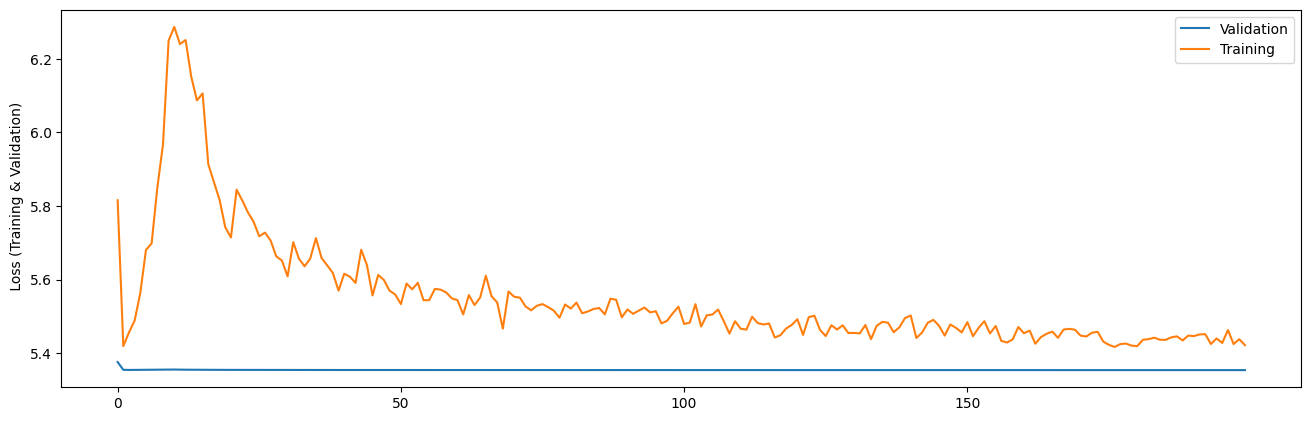

In [8]:
tr = Trainer()
tr.train()